In [ ]:
!pip install pandas seaborn

In [1]:
from random import random, choice
import copy
import math

In [2]:
class ConnectSin:
    YOU = 1
    CPU = -1
    EMPTY = 0
    DRAW = 0
    __CONNECT_NUMBER = 4
    board = None

    def __init__(self, board_size=(6, 7), silent=False):
        """
        The main class for the connect4 game

        Inputs
        ----------
        board_size : a tuple representing the board size in format: (rows, columns)
        silent     : whether the game prints outputs or not
        """
        assert len(board_size) == 2, "board size should be a 1*2 tuple"
        assert board_size[0] > 4 and board_size[1] > 4, "board size should be at least 5*5"

        self.columns = board_size[1]
        self.rows = board_size[0]
        self.silent = silent
        self.board_size = self.rows * self.columns

    def run(self, starter=None):
        """
        runs the game!

        Inputs
        ----------
        starter : either -1,1 or None. -1 if cpu starts the game, 1 if you start the game. None if you want the starter
            to be assigned randomly 

        Output
        ----------
        (int) either 1,0,-1. 1 meaning you have won, -1 meaning the player has won and 0 means that the game has drawn
        """
        if (not starter):
            starter = self.__get_random_starter()
        assert starter in [self.YOU, self.CPU], "starter value can only be 1,-1 or None"
        
        self.__init_board()
        turns_played = 0
        current_player = starter
        while(turns_played < self.board_size):
            
            if (current_player == self.YOU):
                self.__print_board()
                player_input = self.get_your_input()
            elif (current_player == self.CPU):
                player_input = self.__get_cpu_input()
            else:
                raise Exception("A problem has happend! contact no one, there is no fix!")
            if (not self.register_input(player_input, current_player)):
                self.__print("this move is invalid!")
                continue
            current_player = self.__change_turn(current_player)
            potential_winner = self.check_for_winners()
            turns_played += 1
            if (potential_winner != 0):
                self.__print_board()
                self.__print_winner_message(potential_winner)
                return potential_winner
        self.__print_board()
        self.__print("The game has ended in a draw!")
        return self.DRAW

    def evaluate_window(self, window, player_id):
        score = 0
        opp_player = self.CPU if player_id == self.YOU else self.YOU
        if window.count(player_id) == self.__CONNECT_NUMBER:
            score += 100
        elif window.count(player_id) == (self.__CONNECT_NUMBER - 1) and window.count(self.EMPTY) == 1:
            score += 5
        elif window.count(player_id) == (self.__CONNECT_NUMBER - 2) and window.count(self.EMPTY) == 2:
            score += 2
        if window.count(opp_player) == (self.__CONNECT_NUMBER - 1) and window.count(self.EMPTY) == 1:
            score -= 4
        return score
    
    
    def heuristic(self, player_id):
        score = 0

        #evaluate center
        center = [i for i in self.board[:][self.columns//2]]
        center_count = center.count(player_id)
        score += center_count * 3

        ## evaluate horizontal
        for i in range(self.rows):
            rows = [r for r in self.board[i]]
            for j in range(self.rows - self.__CONNECT_NUMBER + 1):
                window = rows[j:j+self.__CONNECT_NUMBER]
                score += self.evaluate_window(window, player_id)

        # evaluate vertical
        for j in range(self.columns):
            cols = []
            for i in range(self.rows):
                cols.append(self.board[i][j])
            for i in range(self.rows - self.__CONNECT_NUMBER + 1):
                window = cols[i:i+self.__CONNECT_NUMBER]
                score += self.evaluate_window(window, player_id)

        # evaluate positive diagonal
        for i in range(self.rows - self.__CONNECT_NUMBER + 1):
            for j in range(self.columns - self.__CONNECT_NUMBER + 1):
                window = [self.board[i+k][j+k] for k in range(self.__CONNECT_NUMBER)]
                score += self.evaluate_window(window, player_id)
        # evaluate negative diagonal
        for i in range(self.rows - self.__CONNECT_NUMBER + 1):
            for j in range(self.columns - self.__CONNECT_NUMBER + 1):
                window = [self.board[i + self.__CONNECT_NUMBER - 1 - k][j+k] for k in range(self.__CONNECT_NUMBER)]
                score += self.evaluate_window(window, player_id)

        return score 
    
    def min_max(self, depth, maximize_player):
        pm = self.get_possible_moves()
        if depth == 0:
              return (None, self.heuristic(self.YOU))
        
        
        check_winner = self.check_for_winners()
        if check_winner != self.EMPTY:
            if check_winner == self.YOU:
                return (None, 100000000000000)
            else:
                return (None, -10000000000000)
              
        if maximize_player:
            value = -math.inf
            column = choice(pm)
            for col in pm:
                b_copy = copy.deepcopy(self.board)
                self.register_input(col, self.YOU)
                new_score = self.min_max(depth - 1, False)[1]
                self.board = b_copy
                if new_score > value:
                    value = new_score
                    column = col
            
            return column, value

        else:
            value = math.inf
            column = choice(pm)
            for col in pm:
                b_copy = copy.deepcopy(self.board)
                self.register_input(col, self.CPU)
                new_score = self.min_max(depth - 1, True)[1]
                self.board = b_copy
                if new_score < value:
                    value = new_score
                    column = col
                
            return column, value
    
    
    def min_max_alphabeta(self, depth, alpha, beta, maximize_player):
        
        pm = self.get_possible_moves()
        if depth == 0:
              return (None, self.heuristic(self.YOU))
        
        
        check_winner = self.check_for_winners()
        if check_winner != self.EMPTY:
            if check_winner == self.YOU:
                return (None, 100000000000000)
            else:
                return (None, -10000000000000)
              
        if maximize_player:
            value = -math.inf
            column = choice(pm)
            for col in pm:
                b_copy = copy.deepcopy(self.board)
                self.register_input(col, self.YOU)
                new_score = self.min_max_alphabeta(depth - 1, alpha, beta, False)[1]
                self.board = b_copy
                if new_score > value:
                    value = new_score
                    column = col
                alpha = max(alpha, value)
                if alpha >= beta:
                    break
            return column, value

        else:
            value = math.inf
            column = choice(pm)
            for col in pm:
                b_copy = copy.deepcopy(self.board)
                self.register_input(col, self.CPU)
                new_score = self.min_max_alphabeta(depth - 1, alpha, beta, True)[1]
                self.board = b_copy
                if new_score < value:
                    value = new_score
                    column = col
                beta = min(beta, value)
                if alpha >= beta:
                    break
                
            return column, value

    
    
    def get_your_input(self):
        """
        gets your input
        Output
        ----------
        (int) an integer between 1 and column count. the column to put a piece in
        """
        #TODO: complete here
        #raise NotImplementedError
        if self.use_alphabeta:
            column, score = self.min_max_alphabeta(self.depth, -math.inf, math.inf,True)
        else:
            column, score = self.min_max(self.depth, True)
        return column
    
    
    def check_for_winners(self):
        """
        checks if anyone has won in this position

        Output
        ----------
        (int) either 1,0,-1. 1 meaning you have won, -1 meaning the player has won and 0 means that nothing has happened
        """
        have_you_won = self.check_if_player_has_won(self.YOU)
        if have_you_won:
            return self.YOU
        has_cpu_won = self.check_if_player_has_won(self.CPU)
        if has_cpu_won:
            return self.CPU
        return self.EMPTY

    def check_if_player_has_won(self, player_id):
        """
        checks if player with player_id has won

        Inputs
        ----------
        player_id : the id for the player to check

        Output
        ----------
        (boolean) true if the player has won in this position
        """
        return (
            self.__has_player_won_diagonally(player_id)
            or self.__has_player_won_horizentally(player_id)
            or self.__has_player_won_vertically(player_id)
        )
    
    def is_move_valid(self, move):
        """
        checks if this move can be played

        Inputs
        ----------
        move : the column to place a piece in, in range [1, column count]

        Output
        ----------
        (boolean) true if the move can be played
        """
        if (move < 1 or move > self.columns):
            return False
        column_index = move - 1
        return self.board[0][column_index] == 0
    
    def get_possible_moves(self):
        """
        returns a list of possible moves for the next move

        Output
        ----------
        (list) a list of numbers of columns that a piece can be placed in
        """
        possible_moves = []
        for i in range(self.columns):
            move = i + 1
            if (self.is_move_valid(move)):
                possible_moves.append(move)
        return possible_moves
    
    def register_input(self, player_input, current_player):
        """
        registers move to board, remember that this function changes the board

        Inputs
        ----------
        player_input : the column to place a piece in, in range [1, column count]
        current_player: ID of the current player, either self.YOU or self.CPU

        """
        if (not self.is_move_valid(player_input)):
            return False
        self.__drop_piece_in_column(player_input, current_player)
        return True

    def __init_board(self):
        self.board = []
        for i in range(self.rows):
            self.board.append([self.EMPTY] * self.columns)

    def __print(self, message: str):
        if not self.silent:
            print(message)

    def __has_player_won_horizentally(self, player_id):
        for i in range(self.rows):
            for j in range(self.columns - self.__CONNECT_NUMBER + 1):
                has_won = True
                for x in range(self.__CONNECT_NUMBER):
                    if self.board[i][j + x] != player_id:
                        has_won = False
                        break
                if has_won:
                    return True
        return False

    def __has_player_won_vertically(self, player_id):
        for i in range(self.rows - self.__CONNECT_NUMBER + 1):
            for j in range(self.columns):
                has_won = True
                for x in range(self.__CONNECT_NUMBER):
                    if self.board[i + x][j] != player_id:
                        has_won = False
                        break
                if has_won:
                    return True
        return False

    def __has_player_won_diagonally(self, player_id):
        for i in range(self.rows - self.__CONNECT_NUMBER + 1):
            for j in range(self.columns - self.__CONNECT_NUMBER + 1):
                has_won = True
                for x in range(self.__CONNECT_NUMBER):
                    if self.board[i + x][j + x] != player_id:
                        has_won = False
                        break
                if has_won:
                    return True
                has_won = True
                for x in range(self.__CONNECT_NUMBER):
                    if self.board[i + self.__CONNECT_NUMBER - 1 - x][j + x] != player_id:
                        has_won = False
                        break
                if has_won:
                    return True
        return False

    def __get_random_starter(self):
        players = [self.YOU, self.CPU]
        return players[int(random() * len(players))]
    
    def __get_cpu_input(self):
        """
        This is where clean code goes to die.
        """
        bb = copy.deepcopy(self.board)
        pm = self.get_possible_moves()
        for m in pm:
            self.register_input(m, self.CPU)
            if (self.check_if_player_has_won(self.CPU)):
                self.board = bb
                return m
            self.board = copy.deepcopy(bb)
        if (self.is_move_valid((self.columns // 2) + 1)):
            c = 0
            cl = (self.columns // 2) + 1
            for x in range(self.rows):
                if (self.board[x][cl] == self.CPU):
                    c += 1
            if (random() < 0.65):
                return cl
        return pm[int(random() * len(pm))]
    
    def __drop_piece_in_column(self, move, current_player):
        last_empty_space = 0
        column_index = move - 1
        for i in range(self.rows):
            if (self.board[i][column_index] == 0):
                last_empty_space = i
        self.board[last_empty_space][column_index] = current_player
        return True
        
    def __print_winner_message(self, winner):
        if (winner == self.YOU):
            self.__print("congrats! you have won!")
        else:
            self.__print("gg. CPU has won!")
    
    def __change_turn(self, turn):
        if (turn == self.YOU): 
            return self.CPU
        else:
            return self.YOU

    def __print_board(self):
        if (self.silent): return
        print("Y: you, C: CPU")
        for i in range(self.rows):
            for j in range(self.columns):
                house_char = "O"
                if (self.board[i][j] == self.YOU):
                    house_char = "Y"
                elif (self.board[i][j] == self.CPU):
                    house_char = "C"
                    
                print(f"{house_char}", end=" ")
            print()


In [3]:
board_sizes_to_check = [(6,7), 
                        (7,8), 
                        (7,10)]
game = ConnectSin(board_size=(6,7),silent=False)
game.use_alphabeta = False
game.depth = 5
game.run()

Y: you, C: CPU
O O O O O O O 
O O O O O O O 
O O O O O O O 
O O O O O O O 
O O O O O O O 
O O O C O O O 
Y: you, C: CPU
O O O O O O O 
O O O O O O O 
O O O O O O O 
O O O O O O O 
O O O C O O O 
O O Y C O O O 
Y: you, C: CPU
O O O O O O O 
O O O O O O O 
O O O C O O O 
O O O Y O O O 
O O O C O O O 
O O Y C O O O 
Y: you, C: CPU
O O O O O O O 
O O O C O O O 
O O O C O O O 
O O O Y O O O 
O O Y C O O O 
O O Y C O O O 
Y: you, C: CPU
O O O C O O O 
O O O C O O O 
O O O C O O O 
O O Y Y O O O 
O O Y C O O O 
O O Y C O O O 
Y: you, C: CPU
O O O C O O O 
O O O C O O O 
O O Y C O O O 
O O Y Y O O O 
O O Y C O O O 
O O Y C O O O 
congrats! you have won!


1

In [4]:
from time import time
import pandas as pd

In [5]:

results_list = []
depth_to_check = [1, 3, 5]
use_alphabeta = False
steps = 3
for b in board_sizes_to_check:
    game = ConnectSin(board_size=b, silent=True)
    game.use_alphabeta = use_alphabeta
    for d in depth_to_check:
        game.depth = d
        res = []
        tic = time()
        for i in range(steps):
            res.append(game.run())
        toc = time() - tic
        results_list.append({'board_size':b, "depth":d, "alphabeta":use_alphabeta,"steps":steps, "victory_chance":res.count(1) / steps, 'execution_time':toc})


In [6]:
depth_to_check = [1, 3, 5, 7]
use_alphabeta = True
steps = 3
for b in board_sizes_to_check:
    game = ConnectSin(board_size=b, silent=True)
    game.use_alphabeta = use_alphabeta
    for d in depth_to_check:
        game.depth = d
        res = []
        tic = time()
        for i in range(steps):
            res.append(game.run())
        toc = time() - tic
        results_list.append({'board_size':b, "depth":d, "alphabeta":use_alphabeta,"steps":steps, "victory_chance":res.count(1) / steps, 'execution_time':toc})


In [29]:
df_res = pd.DataFrame.from_dict(results_list)
sizes = []
for b in df_res['board_size']:
    sizes.append(b[0]*b[1])
df_res["board_size_mult"] = sizes
df_res

,board_size,depth,alphabeta,steps,victory_chance,execution_time,board_size_mult
0,"(6, 7)",1,False,3,1.000000,0.039711,42
1,"(6, 7)",3,False,3,0.666667,1.458906,42
2,"(6, 7)",5,False,3,1.000000,47.273084,42
3,"(7, 8)",1,False,3,0.666667,0.043050,56
4,"(7, 8)",3,False,3,1.000000,2.728847,56
5,"(7, 8)",5,False,3,1.000000,136.605922,56
6,"(7, 10)",1,False,3,0.666667,0.074955,70
7,"(7, 10)",3,False,3,1.000000,6.215615,70
8,"(7, 10)",5,False,3,1.000000,569.881895,70
9,"(6, 7)",1,True,3,0.666667,0.052918,42


In [30]:
df_res.to_csv('df_res.csv')

In [47]:
import seaborn as sns
sns.set()

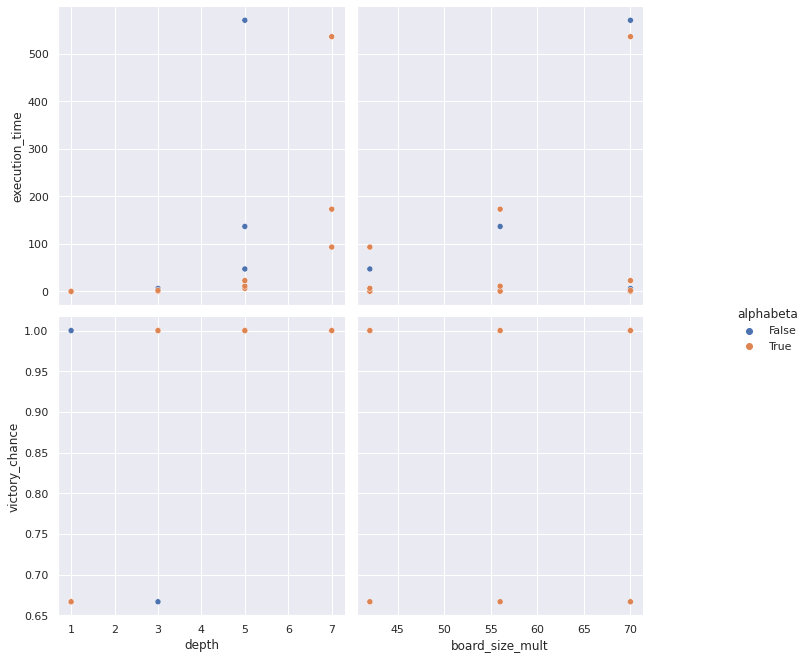

In [57]:

g = sns.pairplot(df_res, x_vars=['depth', 'board_size_mult'], 
             y_vars=['execution_time', 'victory_chance'], hue='alphabeta')
g.fig.set_size_inches(12,10)
g.savefig('pairplot.png')

In [36]:
sns.pairplot?

Signature:
sns.pairplot(
    data,
    *,
    hue=None,
    hue_order=None,
    palette=None,
    vars=None,
    x_vars=None,
    y_vars=None,
    kind='scatter',
    diag_kind='auto',
    markers=None,
    height=2.5,
    aspect=1,
    corner=False,
    dropna=False,
    plot_kws=None,
    diag_kws=None,
    grid_kws=None,
    size=None,
)
Docstring:
Plot pairwise relationships in a dataset.

By default, this function will create a grid of Axes such that each numeric
variable in ``data`` will by shared across the y-axes across a single row and
the x-axes across a single column. The diagonal plots are treated
differently: a univariate distribution plot is drawn to show the marginal
distribution of the data in each column.

It is also possible to show a subset of variables or plot different
variables on the rows and columns.

This is a high-level interface for :class:`PairGrid` that is intended to
make it easy to draw a few common styles. You should use :class:`PairGrid`
directly if you